<a href="https://colab.research.google.com/github/nadiahsahidah/try-sentimen-analysis/blob/main/Sentimen_FIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install Package
!pip install -q transformers google-api-python-client wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import string
import re
import os
import matplotlib.pyplot as plt
import plotly.express as px
import googleapiclient.discovery
from wordcloud import WordCloud
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
filename = 'Dataset Babak Penyisihan.csv'

In [ ]:
data = pd.read_csv(filename)

In [ ]:
data.head()

,label,tweet
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,..."
2,joy,Jumat lalu nonton inih! Selain tertarik settin...
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...
4,love,Happy annyversarry yg pertama kalinya .. Trsra...


#**Preprocessing Data**

Adding additional features - length of, and percentage of punctuations in the text

In [ ]:
import string

def count_punct(text):
    if isinstance(text, str):  # Check if the value is a string
        count = sum([1 for char in text if char in string.punctuation])
        return round(count / (len(text) - text.count(" ")), 3) * 100
    else:
        return 0  # Handle non-string values (e.g., float)

def calculate_tweet_len(text):
    if isinstance(text, str):  # Check if the value is a string
        return len(text) - text.count(" ")
    else:
        return 0  # Handle non-string values (e.g., float)

data['tweet_len'] = data['tweet'].apply(calculate_tweet_len)
data['punct'] = data['tweet'].apply(count_punct)
data.head()

,label,tweet,tweet_len,punct
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2


Cleaning, case folding, remove punct

In [ ]:
def clean_text(text):
  text = re.sub(r'[^a-zA-Z0-9]', ' ', str(text)).lower()
  text = re.sub(r'\b\w(1,2)\b', ' ', text) #menghilangkan 2 kata
  text = re.sub(r'\s\s+', ' ', text)
  text = re.sub(r'\([0-9]+\)|[^a-zA-Z\s]|\(|\)|\d+', '', text)
  text = re.sub(r'\b(?:m{0,4}(?:cm|cd|d?c{0,3})(?:xc|xl|l?x{0,3})(?:ix|iv|v?i{0,3}))\b', ' ', text)
  text = " ".join(text.split())
  return text

data['cleaned_text'] = data['tweet'].apply(lambda x: clean_text(x))
data.head(10)

,label,tweet,tweet_len,punct,cleaned_text
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4,lebih menyeramkan kalo punya grup wa keluarga ...
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3,hepibesdey canteeeekk username panjang umur ja...
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8,jumat lalu nonton inih selain tertarik setting...
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5,nyante dulu sruput kopi biar tambah bijak
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2,happy annyversarry yg pertama kalinya trsrah o...
5,sadness,beli kaos banyak dengan ukuran yg udah downgra...,127,2.4,beli kaos banyak dengan ukuran yg udah downgra...
6,love,Pada saat kamu menangis merengek meminta bonek...,148,4.7,pada saat kamu menangis merengek meminta bonek...
7,anger,[USERNAME] tolong aplikasinya diberesin. Saya ...,121,6.6,username tolong aplikasinya diberesin saya tad...
8,sadness,"Percaya kata lelaki itu, terutama ketika aku i...",192,4.2,percaya kata lelaki itu terutama ketika aku in...
9,sadness,ada saatnya sakit hati itu kita nikmatin denga...,154,2.6,ada saatnya sakit hati itu kita nikmatin denga...


Tokenization

In [ ]:
def tokenize_text(text):
    tokenized_text = text.split()
    return tokenized_text
data['tokens'] = data['cleaned_text'].apply(lambda x: tokenize_text(x))
data.head()

,label,tweet,tweet_len,punct,cleaned_text,tokens
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4,lebih menyeramkan kalo punya grup wa keluarga ...,"[lebih, menyeramkan, kalo, punya, grup, wa, ke..."
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3,hepibesdey canteeeekk username panjang umur ja...,"[hepibesdey, canteeeekk, username, panjang, um..."
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8,jumat lalu nonton inih selain tertarik setting...,"[jumat, lalu, nonton, inih, selain, tertarik, ..."
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5,nyante dulu sruput kopi biar tambah bijak,"[nyante, dulu, sruput, kopi, biar, tambah, bijak]"
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2,happy annyversarry yg pertama kalinya trsrah o...,"[happy, annyversarry, yg, pertama, kalinya, tr..."


-------- skip ----------

Normalisasi

In [ ]:
url = "https://raw.githubusercontent.com/okkyibrohim/id-abusive-language-detection/master/kamusalay.csv"
da1 = pd.read_csv(url)
da1 = da1.rename(columns={'ajh':'alay',
                         'saja':'baku'})
data = data.reset_index(drop=True)
listdf = []
for i in range(len(data)):
    liststr = data['tokens'][i]
    for j in range(len(liststr)):
        for k in range(len(da1['alay'])):
            if liststr[j]==da1['alay'][k]:
                liststr[j] = da1['baku'][k]
                print(da1['alay'][k],'diganti dengan : ',da1['baku'][k])
    liststr = str(liststr).replace('[','')
    liststr = liststr.replace(']','')
    liststr = liststr.replace("'",'')
    liststr = liststr.replace(',','')
    listdf.append(liststr)

#data['normalized'] = data['tokens'].apply(lambda x: listdf.append(liststr))
#data.head(5)

Streaming output truncated to the last 5000 lines.
ga diganti dengan :  tidak
pengen diganti dengan :  ingin
gak diganti dengan :  tidak
gabut diganti dengan :  menganggur
ga diganti dengan :  tidak
udah diganti dengan :  sudah
gak diganti dengan :  tidak
udh diganti dengan :  sudah
ga diganti dengan :  tidak
tau diganti dengan :  tahu
gw diganti dengan :  saya
w diganti dengan :  saya
w diganti dengan :  saya
rmh diganti dengan :  rumah
w diganti dengan :  saya
bs diganti dengan :  bisa
u diganti dengan :  kamu
jgn diganti dengan :  jangan
cewe diganti dengan :  cewek
lu diganti dengan :  kamu
pengen diganti dengan :  ingin
cewe diganti dengan :  cewek
gue diganti dengan :  saya
gue diganti dengan :  saya
jgn diganti dengan :  jangan
w diganti dengan :  saya
bs diganti dengan :  bisa
dah diganti dengan :  sudah
jd diganti dengan :  jadi
jd diganti dengan :  jadi
dah diganti dengan :  sudah
w diganti dengan :  saya
w diganti dengan :  saya
w diganti dengan :  saya
udah diganti dengan :

In [ ]:
listdf

['lebih menyeramkan kalo punya grup wa keluarga yg isinya sharing hadist ayat al qur an dan grup wa lingkungan paroki gereja serem kalo salah reply',
 'hepibesdey canteeeekk username panjang umur jadi pribadi yang jauh lebih baik semoga apa yang cita citakan terwujud dan langgeng sama username',
 'jumat lalu nonton inih selain tertarik settingnya yg jogja aku penasaran stlh baca bahaya laten acak rambut review kak username dan emang bagus banget mata sembab tidak karuan nonton yuk mumpung masih tayang',
 'nyante dulu sruput kopi biar tambah bijak',
 'happy annyversarry yg pertama kalinya trsrah orang mau blng apa aku tidak pdli ini yg aku rasain slma blan aku cukup bhagia sm kamu smuanya baik aja jangan ada mslh yy sayang cemburu krna orang lain wajarkan dan smg kita juga makin mngrti satu sama lain',
 'beli kaos banyak dengan ukuran yg sudah downgrade kucariin kok tidak ada ternyata masuk ke lemari bapak mbak art ku kayaknya tidak notice aku sudah kurusan',
 'pada saat kamu menangis m

In [ ]:
data['normalized'] = listdf
data.head(20)

,label,tweet,tweet_len,punct,cleaned_text,tokens,normalized
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4,lebih menyeramkan kalo punya grup wa keluarga ...,"[lebih, menyeramkan, kalo, punya, grup, wa, ke...",lebih menyeramkan kalo punya grup wa keluarga ...
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3,hepibesdey canteeeekk username panjang umur ja...,"[hepibesdey, canteeeekk, username, panjang, um...",hepibesdey canteeeekk username panjang umur ja...
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8,jumat lalu nonton inih selain tertarik setting...,"[jumat, lalu, nonton, inih, selain, tertarik, ...",jumat lalu nonton inih selain tertarik setting...
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5,nyante dulu sruput kopi biar tambah bijak,"[nyante, dulu, sruput, kopi, biar, tambah, bijak]",nyante dulu sruput kopi biar tambah bijak
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2,happy annyversarry yg pertama kalinya trsrah o...,"[happy, annyversarry, yg, pertama, kalinya, tr...",happy annyversarry yg pertama kalinya trsrah o...
5,sadness,beli kaos banyak dengan ukuran yg udah downgra...,127,2.4,beli kaos banyak dengan ukuran yg udah downgra...,"[beli, kaos, banyak, dengan, ukuran, yg, sudah...",beli kaos banyak dengan ukuran yg sudah downgr...
6,love,Pada saat kamu menangis merengek meminta bonek...,148,4.7,pada saat kamu menangis merengek meminta bonek...,"[pada, saat, kamu, menangis, merengek, meminta...",pada saat kamu menangis merengek meminta bonek...
7,anger,[USERNAME] tolong aplikasinya diberesin. Saya ...,121,6.6,username tolong aplikasinya diberesin saya tad...,"[username, tolong, aplikasinya, diberesin, say...",username tolong aplikasinya diberesin saya tad...
8,sadness,"Percaya kata lelaki itu, terutama ketika aku i...",192,4.2,percaya kata lelaki itu terutama ketika aku in...,"[percaya, kata, lelaki, itu, terutama, ketika,...",percaya kata lelaki itu terutama ketika aku in...
9,sadness,ada saatnya sakit hati itu kita nikmatin denga...,154,2.6,ada saatnya sakit hati itu kita nikmatin denga...,"[ada, saatnya, sakit, hati, itu, kita, nikmati...",ada saatnya sakit hati itu kita nikmatin denga...


----------

Removing Stopword

In [ ]:
from nltk.parse.transitionparser import remove
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

all_stopword = nltk.corpus.stopwords.words('indonesian', 'english')

add_stopword = ['username', 'yg', 'dg', 'rt', 'dgn', 'ny', 'd', 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah', 'aj', 'tp', 'gk', 'lg', 'jg',
                       'gw', 'gua', 'yang', 'kalo', 'kalau', 'jika',
                       'bagaimana', 'siapa', 'dimana', 'kapan']

all_stopword.extend(add_stopword)

# convert list to dictionary
stopwords = set(all_stopword)

#remove stopword pada list token
def stopwords_removal(words):
  return [word for word in words if word not in stopwords]

data['stopword'] = data['tokens'].apply(lambda x: stopwords_removal(x))
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,label,tweet,tweet_len,punct,cleaned_text,tokens,stopword
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4,lebih menyeramkan kalo punya grup wa keluarga ...,"[lebih, menyeramkan, kalo, punya, grup, wa, ke...","[menyeramkan, grup, wa, keluarga, isinya, shar..."
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3,hepibesdey canteeeekk username panjang umur ja...,"[hepibesdey, canteeeekk, username, panjang, um...","[hepibesdey, canteeeekk, umur, pribadi, semoga..."
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8,jumat lalu nonton inih selain tertarik setting...,"[jumat, lalu, nonton, inih, selain, tertarik, ...","[jumat, nonton, inih, tertarik, settingnya, jo..."
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5,nyante dulu sruput kopi biar tambah bijak,"[nyante, dulu, sruput, kopi, biar, tambah, bijak]","[nyante, sruput, kopi, bijak]"
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2,happy annyversarry yg pertama kalinya trsrah o...,"[happy, annyversarry, yg, pertama, kalinya, tr...","[happy, annyversarry, kalinya, trsrah, org, bl..."


Stemming

In [ ]:
!pip install Sastrawi
import nltk
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Fungsi untuk membersihkan dan menerapkan stemming pada tweet
def preprocess_and_stem(tweet):
    # Mengonversi nilai NaN ke dalam string kosong
    tweet = str(tweet)

    # Proses stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_words = [stemmer.stem(word) for word in nltk.word_tokenize(tweet)]

    # Gabungkan kata-kata yang sudah distem
    stemmed_tweet = ' '.join(stemmed_words)

    return stemmed_tweet

# Terapkan fungsi preprocessing dan stemming pada kolom 'tweet'
data['stemmed'] = data['stopword'].apply(preprocess_and_stem)

# Tampilkan data setelah pemrosesan
data.head()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


NameError: ignored

------ skip -------

Lemmatization (keknya ga perlu)

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
def lemmatize_text(token_list):
    return " ".join([lemmatizer.lemmatize(token) for token in token_list if not token in set(all_stopword)])

lemmatizer = nltk.stem.WordNetLemmatizer()
data['lemmatized_tweet'] = data['stopword'].apply(lambda x: lemmatize_text(x))
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,label,tweet,tweet_len,punct,cleaned_text,tokens,normalized,stopword,lemmatized_tweet
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4,lebih menyeramkan kalo punya grup wa keluarga ...,"[lebih, menyeramkan, kalo, punya, grup, wa, ke...",lebih menyeramkan kalo punya grup wa keluarga ...,"[menyeramkan, grup, wa, keluarga, isinya, shar...",menyeramkan grup wa keluarga isinya sharing ha...
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3,hepibesdey canteeeekk username panjang umur ja...,"[hepibesdey, canteeeekk, username, panjang, um...",hepibesdey canteeeekk username panjang umur ja...,"[hepibesdey, canteeeekk, umur, pribadi, semoga...",hepibesdey canteeeekk umur pribadi semoga cita...
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8,jumat lalu nonton inih selain tertarik setting...,"[jumat, lalu, nonton, inih, selain, tertarik, ...",jumat lalu nonton inih selain tertarik setting...,"[jumat, nonton, inih, tertarik, settingnya, jo...",jumat nonton inih tertarik settingnya jogja pe...
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5,nyante dulu sruput kopi biar tambah bijak,"[nyante, dulu, sruput, kopi, biar, tambah, bijak]",nyante dulu sruput kopi biar tambah bijak,"[nyante, sruput, kopi, bijak]",nyante sruput kopi bijak
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2,happy annyversarry yg pertama kalinya trsrah o...,"[happy, annyversarry, yg, pertama, kalinya, tr...",happy annyversarry yg pertama kalinya trsrah o...,"[happy, annyversarry, kalinya, trsrah, orang, ...",happy annyversarry kalinya trsrah orang blng p...


Labeling

In [ ]:
data['LABEL'] = data['label'].map({'anger':1, 'sadness':2, 'fear':3, 'joy':4, 'love':5})
data.head()

,label,tweet,tweet_len,punct,cleaned_text,tokens,stopword,lemmatized_tweet,stemmed,LABEL,Polarity
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4,lebih menyeramkan kalo punya grup wa keluarga ...,"[lebih, menyeramkan, kalo, punya, grup, wa, ke...","[menyeramkan, grup, wa, keluarga, isinya, shar...",menyeramkan grup wa keluarga isinya sharing ha...,seram grup wa keluarga isi sharing ...,3.0,0
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3,hepibesdey canteeeekk username panjang umur ja...,"[hepibesdey, canteeeekk, username, panjang, um...","[hepibesdey, canteeeekk, umur, pribadi, semoga...",hepibesdey canteeeekk umur pribadi semoga cita...,hepibesdey canteeeekk umur pribadi mo...,4.0,1
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8,jumat lalu nonton inih selain tertarik setting...,"[jumat, lalu, nonton, inih, selain, tertarik, ...","[jumat, nonton, inih, tertarik, settingnya, jo...",jumat nonton inih tertarik settingnya jogja pe...,jumat nonton inih tarik settingnya ...,4.0,1
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5,nyante dulu sruput kopi biar tambah bijak,"[nyante, dulu, sruput, kopi, biar, tambah, bijak]","[nyante, sruput, kopi, bijak]",nyante sruput kopi bijak,nyante sruput kopi bijak,4.0,1
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2,happy annyversarry yg pertama kalinya trsrah o...,"[happy, annyversarry, yg, pertama, kalinya, tr...","[happy, annyversarry, kalinya, trsrah, org, bl...",happy annyversarry kalinya trsrah org blng pdl...,happy annyversarry kali trsrah org ...,5.0,1


---------

#Analisis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153 entries, 0 to 5152
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   label         4153 non-null   object 
 1   tweet         5151 non-null   object 
 2   tweet_len     5153 non-null   int64  
 3   punct         5153 non-null   float64
 4   cleaned_text  5153 non-null   object 
 5   tokens        5153 non-null   object 
 6   stopword      5153 non-null   object 
 7   stemmed       5153 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 322.2+ KB


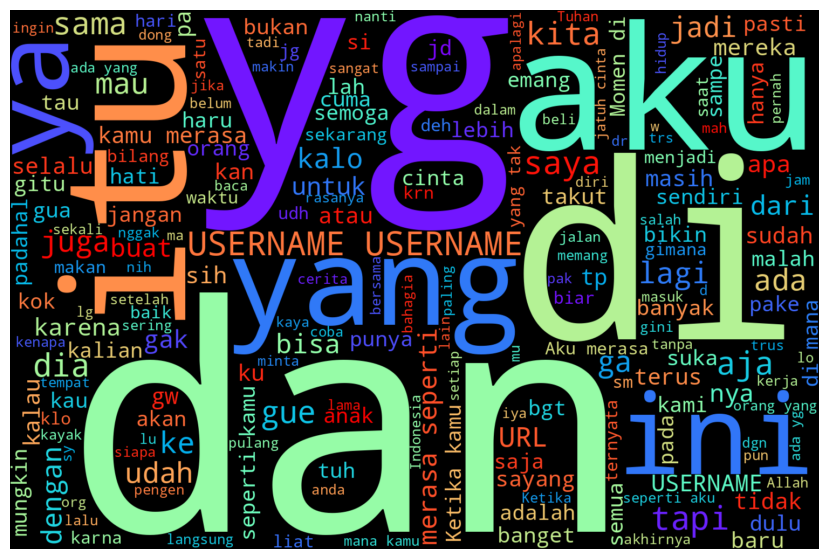

In [ ]:
# Combine all tweet into a single string
all_tweet = " ".join(str(tweet) for tweet in data['tweet'])

# Create a WordCloud object with black background and rainbow colors
wordcloud = WordCloud(
    background_color='black',  # Set background color to black
    colormap='rainbow',        # Set colormap to rainbow
    width=1500,                 # Set the width of the word cloud image
    height=1000,                # Set the height of the word cloud image
    max_words=200,             # Maximum number of words to include in the word cloud
    random_state=42            # Set a random state for reproducibility
).generate(all_tweet)

# Display the word cloud using matplotlib
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
# Define the model name
model_name = "StevenLimcorn/indonesian-roberta-base-emotion-classifier"

pipe = pipeline(
"text-classification",
model=model_name)

In [ ]:
pipe("Happy Mensive My Love makasih udh nemenin selama tiga bulan ini. ga kerasa udh panjang aja perjalanannya, selama ini aku ngerasa belum ngasih apa apa buat kamu maaf aku ga bisa romantis, kerjaan aku cuma jailin kamu. tapi kamu harus percaya tiap detik aku selalu sayang kamu")

[{'label': 'love', 'score': 0.9871297478675842}]

In [ ]:
# Get details about the model
model = AutoModelForSequenceClassification.from_pretrained(model_name)
print("\nModel details:")
print(model)


Model details:
RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [ ]:
label = []
score = []
for i in data['tokens']:
  sentimen_list = pipe(i)
  label.append(sentimen_list[0]['label'])
  score.append(sentimen_list[0]['score'])

In [ ]:
data_out = data.copy()

In [ ]:
data_out['label'] = label
data_out['score'] = score

In [ ]:
data_out

,label,tweet,tweet_len,punct,cleaned_text,tokens,stopword,stemmed,score
0,sadness,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4,lebih menyeramkan kalo punya grup wa keluarga ...,"[lebih, menyeramkan, kalo, punya, grup, wa, ke...","[menyeramkan, grup, wa, keluarga, isinya, shar...",seram grup wa keluarga isi sharing ...,0.906889
1,sadness,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3,hepibesdey canteeeekk username panjang umur ja...,"[hepibesdey, canteeeekk, username, panjang, um...","[hepibesdey, canteeeekk, umur, pribadi, semoga...",hepibesdey canteeeekk umur pribadi mo...,0.935165
2,anger,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8,jumat lalu nonton inih selain tertarik setting...,"[jumat, lalu, nonton, inih, selain, tertarik, ...","[jumat, nonton, inih, tertarik, settingnya, jo...",jumat nonton inih tarik settingnya ...,0.735317
3,love,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5,nyante dulu sruput kopi biar tambah bijak,"[nyante, dulu, sruput, kopi, biar, tambah, bijak]","[nyante, sruput, kopi, bijak]",nyante sruput kopi bijak,0.736771
4,happy,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2,happy annyversarry yg pertama kalinya trsrah o...,"[happy, annyversarry, yg, pertama, kalinya, tr...","[happy, annyversarry, kalinya, trsrah, org, bl...",happy annyversarry kali trsrah org ...,0.792311
...,...,...,...,...,...,...,...,...,...
5148,love,Aku termasuk orang yang tidak habis pikir deng...,210,1.4,aku termasuk orang yang tidak habis pikir deng...,"[aku, termasuk, orang, yang, tidak, habis, pik...","[orang, habis, pikir, orang, menganggap, wajar...",orang habis pikir orang anggap waja...,0.864702
5149,sadness,"Melawan sibuk Selasamu, jangan patah semangat ...",44,4.5,melawan sibuk selasamu jangan patah semangat yah,"[melawan, sibuk, selasamu, jangan, patah, sema...","[melawan, sibuk, selasamu, patah, semangat]",lawan sibuk selasa patah semangat,0.862737
5150,sadness,Momen di mana kamu merasa begitu mendalam terh...,134,2.2,momen mana kamu merasa begitu mendalam terhubu...,"[momen, mana, kamu, merasa, begitu, mendalam, ...","[momen, mendalam, terhubung, energi, positif, ...",momen dalam hubung energi positif i...,0.899172
5151,sadness,Tapi tentunya secara ini Bekasi ada hal-hal yg...,223,5.4,tapi tentunya secara ini bekasi ada hal hal yg...,"[tapi, tentunya, secara, ini, bekasi, ada, hal...","[bekasi, sayangnya, terelakkan, bekasi, panas,...",bekas sayang elak bekas panas bange...,0.843738


In [ ]:
import plotly.express as px

# Generate label counts
label_counts = data_out['label'].value_counts()

# Create a pie chart
fig = px.pie(
    label_counts,
    values=label_counts.values,
    names=label_counts.index,
    title="Sentiment Distribution",
)

# Update layout for better readability
fig.update_layout(title_text="Sentiment Distribution", showlegend=True)

# Show the pie chart
fig.show()


In [ ]:
data_anger = data_out[data_out['label']=='anger']

In [ ]:
data_anger

,label,tweet,tweet_len,punct,cleaned_text,tokens,stopword,stemmed,score
2,anger,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8,jumat lalu nonton inih selain tertarik setting...,"[jumat, lalu, nonton, inih, selain, tertarik, ...","[jumat, nonton, inih, tertarik, settingnya, jo...",jumat nonton inih tarik settingnya ...,0.735317
7,anger,[USERNAME] tolong aplikasinya diberesin. Saya ...,121,6.6,username tolong aplikasinya diberesin saya tad...,"[username, tolong, aplikasinya, diberesin, say...","[tolong, aplikasinya, diberesin, pesan, server...",tolong aplikasi resin pesan server ...,0.654752
10,anger,Penyelamat saat laper ya cuma Pop Mie sob. Ena...,129,3.1,penyelamat saat laper ya cuma pop mie sob enak...,"[penyelamat, saat, laper, ya, cuma, pop, mie, ...","[penyelamat, laper, pop, mie, sob, enaknya, na...",selamat laper pop mie sob enak na...,0.683033
17,anger,Seharusnya yg harus marah itu JKT58 (yg milih)...,188,4.3,seharusnya yg harus marah itu jkt yg milih klo...,"[seharusnya, yg, harus, marah, itu, jkt, yg, m...","[marah, jkt, milih, ngerasa, kemunduran, lu, o...",marah jkt milih ngerasa mundur lu ...,0.797190
22,anger,[USERNAME] dari tadi pagi saya tidak bisa masu...,153,7.8,username dari tadi pagi saya tidak bisa masuk ...,"[username, dari, tadi, pagi, saya, tidak, bisa...","[pagi, masuk, web, jadwalnya, jam, masuk, web,...",pagi masuk web jadwal jam masuk w...,0.654752
...,...,...,...,...,...,...,...,...,...
5111,anger,"Lucky me, ada yg sebegini kangen dan sayang sa...",202,2.0,lucky me ada yg sebegini kangen dan sayang sam...,"[lucky, me, ada, yg, sebegini, kangen, dan, sa...","[lucky, me, kangen, sayang, uwe, dirantauan, g...",lucky me kangen sayang uwe rantau ...,0.375740
5124,anger,[USERNAME] [USERNAME] [USERNAME] [USERNAME] Ma...,124,8.1,username username username username masalahnya...,"[username, username, username, username, masal...","[uang, konsumsi, buka, puasa, bareng, anak, ya...",uang konsumsi buka puasa bareng ana...,0.654752
5130,anger,[USERNAME] Not only educated...tapi jd lah seo...,177,7.3,username not only educated tapi jd lah seorang...,"[username, not, only, educated, tapi, jd, lah,...","[not, only, educated, isteri, sahabat, kekasih...",not only educated isteri sahabat ka...,0.654752
5137,anger,[USERNAME] Sama email traveloka terus. Telfon ...,218,3.2,username sama email traveloka terus telfon cal...,"[username, sama, email, traveloka, terus, telf...","[email, traveloka, telfon, call, center, cuman...",email traveloka telfon call center ...,0.654752


------

**EDA**

In [ ]:
#Shape of the dataset, and breakdown of the classes
print(f"Input data has {len(data)} rows and {len(data.columns)} columns")
print(f"label anger = {len(data[data['label']=='anger'])} rows")
print(f"label sadness = {len(data[data['label']=='sadness'])} rows")
print(f"label fear = {len(data[data['label']=='fear'])} rows")
print(f"label joy = {len(data[data['label']=='joy'])} rows")
print(f"label love = {len(data[data['label']=='love'])} rows")

Input data has 5153 rows and 8 columns
label anger = 876 rows
label sadness = 1123 rows
label fear = 654 rows
label joy = 1002 rows
label love = 498 rows


Number of null in label: 1000
Number of null in text: 2


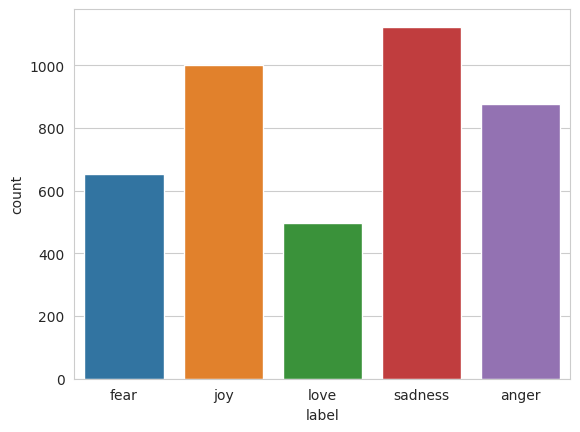

In [ ]:
# Missing values in the dataset
print(f"Number of null in label: { data['label'].isnull().sum() }")
print(f"Number of null in text: { data['tweet'].isnull().sum()}")
sns.countplot(x='label', data=data);

-----

**Feature Extraction from Text**

konversi label ke polaritas

In [ ]:
def convert(LABEL):
  if LABEL == 1.0:
    return 1
  elif LABEL == 2.0:
    return 2
  elif LABEL == 3.0:
    return 3
  elif LABEL == 4.0:
    return 4
  else:
    return 5

In [ ]:
data['Polarity'] = data['LABEL'].apply(convert)

In [ ]:
x = data['stopword']
y = data['Polarity']

* Vectorizer : TF-IDF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()
text_tf = tf.fit_transform(data['stopword'].astype('U'))
text_tf

<5153x18518 sparse matrix of type '<class 'numpy.float64'>'
	with 68876 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text_tf, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3607, 18518)
(1546, 18518)
(3607,)
(1546,)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df = 0.5, min_df = 2) # ignore terms that occur in more than 50% documents and the ones that occur in less than 2
tfidf_train = tfidf.fit_transform(X_train['lemmatized_tweet'])
tfidf_test = tfidf.transform(X_test['lemmatized_tweet'])

X_train_vect = pd.concat([X_train[['tweet_len', 'punct']].reset_index(drop=True),
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['tweet_len', 'punct']].reset_index(drop=True),
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()


IndexError: ignored

Algoritma : Multinomial Naive Bayes

In [ ]:
# Performa algoritma naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)
print("MultinomialNB Accuracy:" , accuracy_score(y_test, predicted))
print("MultinomialNB Precision:", precision_score(y_test, predicted, average="macro", pos_label=0))
print("MultinomialNB Recall:", recall_score(y_test, predicted, average="macro", pos_label=0))
print("MultinomialNB F1_score:", f1_score(y_test, predicted, average="macro", pos_label=0))

print(f'confussion matrix:\n {confusion_matrix(y_test, predicted)}')
print('===============================================\n')
print(classification_report(y_test, predicted, zero_division=0))

MultinomialNB Accuracy: 0.4217335058214748
MultinomialNB Precision: 0.6165342480476796
MultinomialNB Recall: 0.3435762198070108
MultinomialNB F1_score: 0.3496926682511445
confussion matrix:
 [[ 42  15   0   2 191]
 [  2 125   0   8 192]
 [  1  17  21   1 149]
 [  0  22   0  67 217]
 [ 25  35   5  12 397]]

              precision    recall  f1-score   support

           1       0.60      0.17      0.26       250
           2       0.58      0.38      0.46       327
           3       0.81      0.11      0.20       189
           4       0.74      0.22      0.34       306
           5       0.35      0.84      0.49       474

    accuracy                           0.42      1546
   macro avg       0.62      0.34      0.35      1546
weighted avg       0.57      0.42      0.38      1546



In [ ]:
# Preprocessing data tweet baru (gantilah dengan praproses sesuai dengan kebutuhan Anda)
new_tweet = "Aku merasa seperti aku harus berjuang untuk menahan kemarahan yang menggelegak."

# Transformasi data tweet baru menjadi representasi TF-IDF
new_tweet_tfidf = tf.transform([new_tweet])

# Prediksi emosi menggunakan model yang telah terlatih (nb_classifier adalah model Naive Bayes yang telah terlatih)
predicted_emotion = clf.predict(new_tweet_tfidf)

In [ ]:
if predicted_emotion == [1]:
  print("Anger")
elif predicted_emotion == [2]:
  print("Sadness")
elif predicted_emotion == [3]:
  print("Fear")
elif predicted_emotion == [4]:
  print("Joy")
else:
  print("Love")

Love


In [ ]:
data.to_csv('data.csv')